In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
plt.rcParams["figure.autolayout"] = True

In [2]:
import torch
from torch import nn, optim
from utils import Legendre_Polynomials, Finite_Elements
import torch.nn.functional as F

## Define the parameters of the equation

In [96]:
# f = lambda x: x ** -.25  # Source function
f = lambda x: 10  # Source function
k = 2. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 5., 0.  # Values at the boundaries

## Train the neural network

In [97]:
from solvers import Exact_HelmholtzImpedance_const
u, u_x, u_xx = Exact_HelmholtzImpedance_const(f(0), k, a, b, ga, gb)

# Check that the solution satisfies boundary conditions
assert np.allclose(- u_x(a) - 1j * k * u(a), ga)
assert np.allclose(+ u_x(b) - 1j * k * u(b), gb)
for x in np.linspace(a, b, 100):
    assert np.allclose(- u_xx(x) - k ** 2 * u(x), f(x))

In [169]:
from solvers import VPINN_HelmholtzImpedance

testfuncs = 10
width = 10
depth = 1
activation = F.relu
penalty = None

cuda = False
epochs = 60000
lr = 1e-01
seed = None
dropout_probs = None

model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                N_quad=900,
                                seed=seed,
                                cuda=cuda,
                                )

# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)()
testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)()
if cuda:
  model = model.cuda()
# optimizer = optim.Adam([
#   {'params': model.lins[0].weight, 'lr': 0},
#   {'params': model.lins[0].bias, 'lr': 0},
#   {'params': model.lins[1].weight, 'lr': lr},
#   {'params': model.lins[1].bias, 'lr': 0},
#   ], lr=lr)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=50, min_lr=1e-08, verbose=True)
# losses, errors = model.train_(testfunctions, epochs, optimizer, scheduler, exact=(u, u_x))

/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:331: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:332: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


### Perfect initialization

In [170]:
# points = torch.linspace(a - 1e-06, b, width + 1).float()
# derivs = torch.zeros_like(model.lins[1].weight)
# for i, point, next in zip(range(width), points[:-1], points[1:]):
#     derivs[0, i] = .5 * (u_x(point).real + u_x(next).real)
#     derivs[1, i] = .5 * (u_x(point).imag + u_x(next).imag)
# steps = derivs.clone()
# for i in range(width - 1):
#     steps[0, i + 1] = derivs[0, i + 1] - derivs[0, i]
#     steps[1, i + 1] = derivs[1, i + 1] - derivs[1, i]

# model.lins[0].bias = nn.Parameter(-1 * points[:-1])
# model.lins[1].weight = nn.Parameter(steps.float())
# model.lins[1].bias = nn.Parameter(torch.tensor([u(a).real, u(a).imag]).float())

### To debug

In [125]:
K = len(testfunctions)

loss_re, loss_im = 0, 0
for k, v_k in enumerate(testfunctions):
    res_re, res_im = model.res(v_k, i=2)
    loss_re += res_re.pow(2).item() / K
    loss_im += res_im.pow(2).item() / K
    print(f'k = {k}, real: {res_re.pow(2).item() / K:.2e}, imag: {res_im.pow(2).item() / K:.2e}')
print(f'{loss_re:.2e}, {loss_im:.2e}')

v_k = testfunctions[6]

# res_re, res_im = model.res(v_k, i=2)
# res_re.pow(2).item() / K + res_im.pow(2).item() / K

# def func_x(x):
#     x.requires_grad = False
#     ans = u_x(x) * v_k.deriv(1)(x)
#     return ans.real
#     # ans = model.deriv(1, x)[0] * v_k.deriv(1)(x)
#     # return ans

# def func(x):
#     x.requires_grad = False
#     ans = u(x) * v_k(x)
#     return ans.real
#     # ans = model(x)[:, 0].view(-1, 1) * v_k(x)
#     # return ans

# intgfunc_x = model.intg(func_x)
# intgfunc = model.intg(func)
# intgfunc_x - intgfunc

k = 0, real: 4.44e+00, imag: 1.20e-03
k = 1, real: 2.75e+00, imag: 4.61e-03
k = 2, real: 8.72e+00, imag: 2.48e-01
k = 3, real: 2.06e+01, imag: 9.25e-01
k = 4, real: 3.47e+01, imag: 3.06e+00
k = 5, real: 5.22e+01, imag: 7.29e+00
k = 6, real: 7.67e+01, imag: 2.17e+01
k = 7, real: 1.07e+02, imag: 5.39e+01
k = 8, real: 1.52e+02, imag: 1.18e+02
k = 9, real: 1.56e+00, imag: 1.56e+02
4.61e+02, 3.61e+02


### Custom training

In [171]:
optimizer = optim.Adam([
  # {'params': model.lins[0].weight, 'lr': 1e-02},
  # {'params': model.lins[0].bias, 'lr': 1e-04},
  {'params': model.lins[1].weight, 'lr': 1e-02},
  {'params': model.lins[1].bias, 'lr': 1e-05},
  ], lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=100, threshold=1e-03, min_lr=1e-08, verbose=True)
losses, errors = model.train_(testfunctions, 10000, optimizer, scheduler, exact=(u, u_x))

Epoch 000000 / 10000: loss = 9.696e+02, H1-error = 2.515e+02
Epoch 000050 / 10000: loss = 2.437e+02, H1-error = 2.303e+02
Epoch 000100 / 10000: loss = 1.948e+02, H1-error = 2.176e+02
Epoch 000150 / 10000: loss = 1.608e+02, H1-error = 2.103e+02
Epoch 000200 / 10000: loss = 1.361e+02, H1-error = 2.089e+02
Epoch 000250 / 10000: loss = 1.190e+02, H1-error = 2.101e+02
Epoch 000300 / 10000: loss = 1.075e+02, H1-error = 2.114e+02
Epoch 000350 / 10000: loss = 9.968e+01, H1-error = 2.115e+02
Epoch 000400 / 10000: loss = 9.397e+01, H1-error = 2.102e+02
Epoch 000450 / 10000: loss = 8.944e+01, H1-error = 2.075e+02
Epoch 000500 / 10000: loss = 8.555e+01, H1-error = 2.039e+02
Epoch 000550 / 10000: loss = 8.206e+01, H1-error = 1.999e+02
Epoch 000600 / 10000: loss = 7.883e+01, H1-error = 1.959e+02
Epoch 000650 / 10000: loss = 7.584e+01, H1-error = 1.922e+02
Epoch 000700 / 10000: loss = 7.305e+01, H1-error = 1.889e+02
Epoch 000750 / 10000: loss = 7.046e+01, H1-error = 1.861e+02
Epoch 000800 / 10000: lo

KeyboardInterrupt: 

## Plot the parameters

In [ ]:
# for n, p in model.named_parameters():
#     print(n, p)

Last layer bias: Parameter containing:
tensor([1., 1.], requires_grad=True)


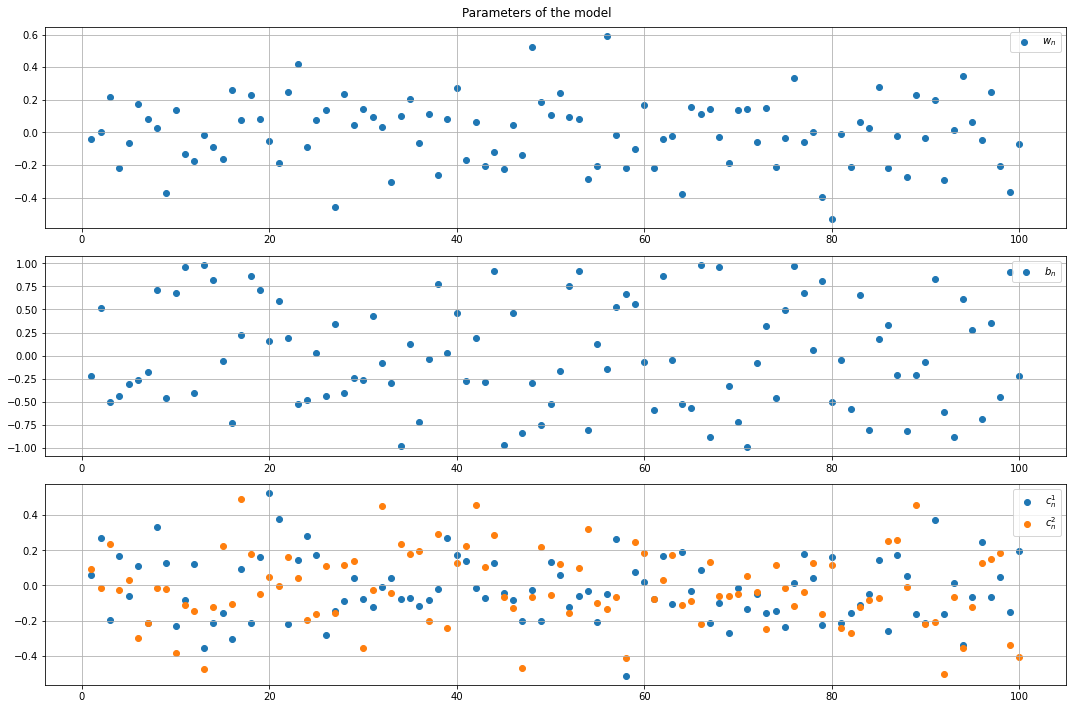

In [156]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=4.0)
fig.suptitle(f'Parameters of the model')

axs[0].scatter(np.arange(1, width + 1), model.lins[0].weight.detach().view(-1).numpy(), label='$w_n$')
axs[1].scatter(np.arange(1, width + 1), model.lins[0].bias.detach().view(-1).numpy(), label='$b_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[0].detach().view(-1).numpy(), label='$c^1_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[1].detach().view(-1).numpy(), label='$c^2_n$')
for ax in axs:
    ax.grid()
    ax.legend()

print(f'Last layer bias: {model.lins[1].bias}')

## Evaluate the results

In [122]:
errs = model.H1_error(u, u_x)
print(f'H1-error: \t\t{errs[0].item():.2e}')
print(f'Solution L2-error: \t{errs[1].item():.2e}')
print(f'Derivative L2-error: {errs[2].item():.2e}')

H1-error: 		2.84e+00
Solution L2-error: 	3.08e-02
Derivative L2-error: 2.81e+00


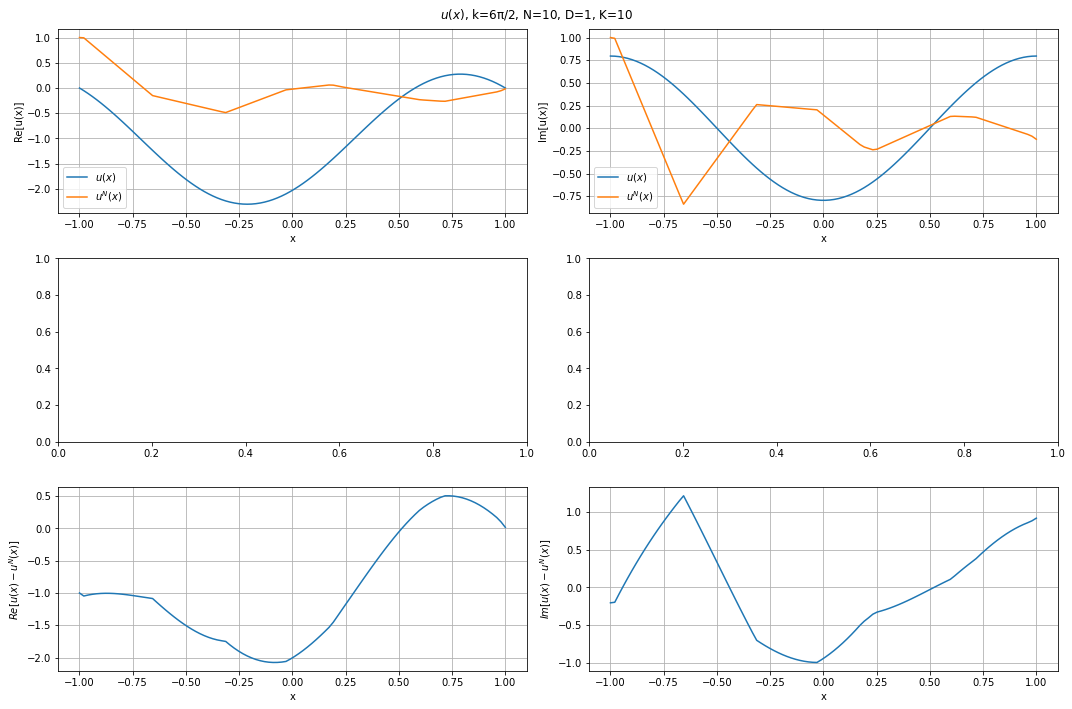

In [172]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u(xpts).real, u(xpts).imag
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts.real, yerr=upts.real - rpts.real, ecolor='black', label='$u(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts.imag, yerr=upts.imag - rpts.imag, ecolor='black', label='$u(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

axs[2, 0].plot(xpts, upts_re - rpts_re)
axs[2, 0].set(xlabel='x', ylabel='$Re[u(x)-u^N(x)]$')
axs[2, 0].grid()
axs[2, 1].plot(xpts, upts_im - rpts_im)
axs[2, 1].set(xlabel='x', ylabel='$Im[u(x)-u^N(x)]$')
axs[2, 1].grid()

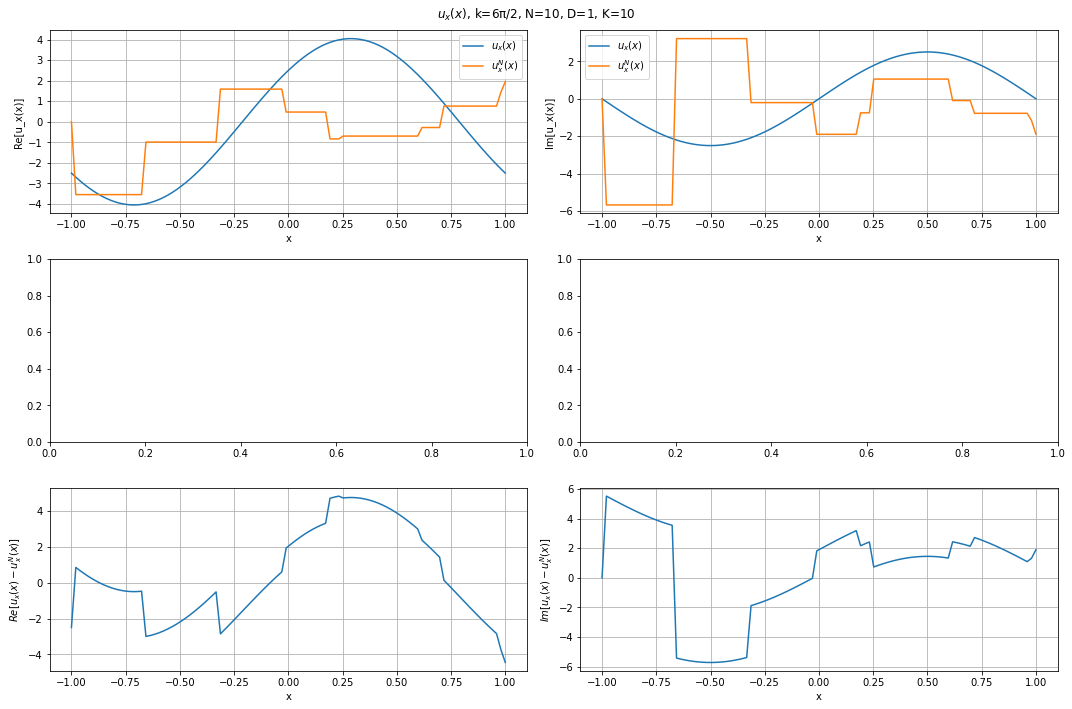

In [173]:
xpts = torch.linspace(a, b, 100).float().view(-1, 1)

model.eval()
upts_re, upts_im = u_x(xpts).real, u_x(xpts).imag
xpts.requires_grad_()
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy()
    rpts_re = rpts_re.numpy()
    rpts_im = rpts_im.numpy()

plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 2)
fig.tight_layout(pad=4.0)
fig.suptitle(f'$u_x(x)$, k={round(model.k.item() / (np.pi / 2))}π/2, N={width}, D={depth}, K={testfuncs}')

axs[0, 0].plot(xpts, upts_re, label='$u_x(x)$')
axs[0, 0].plot(xpts, rpts_re, label='$u^N_x(x)$')
axs[0, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
axs[0, 0].legend()
axs[0, 0].grid()
axs[0, 1].plot(xpts, upts_im, label='$u_x(x)$')
axs[0, 1].plot(xpts, rpts_im, label='$u^N_x(x)$')
axs[0, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
axs[0, 1].legend()
axs[0, 1].grid()

# axs[1, 0].errorbar(xpts, upts_re, yerr=upts_re - rpts_re, ecolor='black', label='$u_x(x)$')
# axs[1, 0].set(xlabel='x', ylabel='Re[u_x(x)]')
# axs[1, 0].legend()
# axs[1, 0].grid()
# axs[1, 1].errorbar(xpts, upts_im, yerr=upts_im - rpts_im, ecolor='black', label='$u_x(x)$')
# axs[1, 1].set(xlabel='x', ylabel='Im[u_x(x)]')
# axs[1, 1].legend()
# axs[1, 1].grid()

axs[2, 0].plot(xpts, upts_re - rpts_re)
axs[2, 0].set(xlabel='x', ylabel='$Re[u_x(x)-u^N_x(x)]$')
axs[2, 0].grid()
axs[2, 1].plot(xpts, upts_im - rpts_im)
axs[2, 1].set(xlabel='x', ylabel='$Im[u_x(x)-u^N_x(x)]$')
axs[2, 1].grid()